In \[2\]:

    pip install pyspark

    Requirement already satisfied: pyspark in /usr/local/spark/python (3.5.0)
    Requirement already satisfied: py4j==0.10.9.7 in /opt/conda/lib/python3.11/site-packages (from pyspark) (0.10.9.7)
    Note: you may need to restart the kernel to use updated packages.

In \[3\]:

    !pip install py4j

    Requirement already satisfied: py4j in /opt/conda/lib/python3.11/site-packages (0.10.9.7)

In \[4\]:

    !python3 -c "import pyspark; print(pyspark.__version__)"

    3.5.0

## Import Necessary Libraries

In \[4\]:

    import matplotlib.pyplot as plt
    import pandas as pd
    from pyspark.sql.functions import date_format
    from pyspark.sql.functions import count
    from pyspark.sql.functions import to_timestamp
    from pyspark.sql.functions import year
    from pyspark.sql.functions import sum as spark_sum
    from pyspark.sql.functions import explode, col
    from pyspark.sql.functions import sum as spark_sum, count

In \[5\]:

    from pyspark.sql import SparkSession

    spark = SparkSession.builder \
        .appName("Ecommerce Big Data Visualization") \
        .getOrCreate()

    spark

Out\[5\]:

**SparkSession - in-memory**

**SparkContext**

[Spark UI](http://d1b837b3df99:4041)

Version  
`v3.5.0`

Master  
`local[*]`

AppName  
`Ecommerce Big Data Visualization`

## Load data (into Notebook Cell)

## Load Transactions

In \[6\]:

    transactions = spark.read.json("/project/data_raw/transactions.json")
    transactions.printSchema()
    transactions.show(5, truncate=False)

    root
     |-- discount: double (nullable = true)
     |-- items: array (nullable = true)
     |    |-- element: struct (containsNull = true)
     |    |    |-- product_id: string (nullable = true)
     |    |    |-- quantity: long (nullable = true)
     |    |    |-- subtotal: double (nullable = true)
     |    |    |-- unit_price: double (nullable = true)
     |-- payment_method: string (nullable = true)
     |-- session_id: string (nullable = true)
     |-- status: string (nullable = true)
     |-- subtotal: double (nullable = true)
     |-- timestamp: string (nullable = true)
     |-- total: double (nullable = true)
     |-- transaction_id: string (nullable = true)
     |-- user_id: string (nullable = true)

    +--------+--------------------------------------------------------------------------------------------------+--------------+---------------+----------+--------+-------------------+-------+----------------+-----------+
    |discount|items                                                                                             |payment_method|session_id     |status    |subtotal|timestamp          |total  |transaction_id  |user_id    |
    +--------+--------------------------------------------------------------------------------------------------+--------------+---------------+----------+--------+-------------------+-------+----------------+-----------+
    |0.0     |[{prod_00764, 1, 288.88, 288.88}, {prod_00747, 1, 421.93, 421.93}, {prod_01719, 3, 203.91, 67.97}]|paypal        |sess_e3e3b9e3e7|completed |914.72  |2025-12-27T14:56:06|914.72 |txn_f7ad4fe35473|user_001153|
    |0.0     |[{prod_01956, 3, 598.44, 199.48}]                                                                 |bank_transfer |sess_d8ef5aa89d|completed |598.44  |2026-01-18T03:25:23|598.44 |txn_19e58269172c|user_002054|
    |95.29   |[{prod_02959, 2, 547.04, 273.52}, {prod_00728, 2, 405.9, 202.95}]                                 |gift_card     |NULL           |processing|952.94  |2026-01-21T08:00:37|857.65 |txn_70a30f957844|user_002767|
    |231.04  |[{prod_02741, 3, 1315.89, 438.63}, {prod_02056, 3, 224.4, 74.8}]                                  |apple_pay     |sess_3fc89f798d|completed |1540.29 |2025-12-26T00:20:54|1309.25|txn_2aaa4dee673e|user_002710|
    |0.0     |[{prod_01552, 3, 396.48, 132.16}]                                                                 |credit_card   |sess_ad923e241d|completed |396.48  |2026-01-09T07:14:31|396.48 |txn_c00b051503f8|user_004528|
    +--------+--------------------------------------------------------------------------------------------------+--------------+---------------+----------+--------+-------------------+-------+----------------+-----------+
    only showing top 5 rows

## Load Products

In \[7\]:

    products = spark.read.json("/project/data_raw/products.json")

## Convert a small sample to Pandas

In \[8\]:

    pdf_transactions = transactions.limit(20).toPandas()
    pdf_transactions

Out\[8\]:

|     | discount | items                                              | payment_method | session_id      | status     | subtotal | timestamp           | total   | transaction_id   | user_id     |
|-----|----------|----------------------------------------------------|----------------|-----------------|------------|----------|---------------------|---------|------------------|-------------|
| 0   | 0.00     | \[(prod_00764, 1, 288.88, 288.88), (prod_00747,... | paypal         | sess_e3e3b9e3e7 | completed  | 914.72   | 2025-12-27T14:56:06 | 914.72  | txn_f7ad4fe35473 | user_001153 |
| 1   | 0.00     | \[(prod_01956, 3, 598.44, 199.48)\]                | bank_transfer  | sess_d8ef5aa89d | completed  | 598.44   | 2026-01-18T03:25:23 | 598.44  | txn_19e58269172c | user_002054 |
| 2   | 95.29    | \[(prod_02959, 2, 547.04, 273.52), (prod_00728,... | gift_card      | None            | processing | 952.94   | 2026-01-21T08:00:37 | 857.65  | txn_70a30f957844 | user_002767 |
| 3   | 231.04   | \[(prod_02741, 3, 1315.89, 438.63), (prod_02056... | apple_pay      | sess_3fc89f798d | completed  | 1540.29  | 2025-12-26T00:20:54 | 1309.25 | txn_2aaa4dee673e | user_002710 |
| 4   | 0.00     | \[(prod_01552, 3, 396.48, 132.16)\]                | credit_card    | sess_ad923e241d | completed  | 396.48   | 2026-01-09T07:14:31 | 396.48  | txn_c00b051503f8 | user_004528 |
| 5   | 0.00     | \[(prod_00709, 1, 269.18, 269.18)\]                | bank_transfer  | sess_1ba38f2291 | completed  | 269.18   | 2026-01-21T04:39:24 | 269.18  | txn_71093a50af92 | user_004573 |
| 6   | 0.00     | \[(prod_02175, 2, 405.36, 202.68), (prod_02662,... | paypal         | None            | completed  | 1855.96  | 2025-11-23T04:40:20 | 1855.96 | txn_a1c0704eb83e | user_002305 |
| 7   | 0.00     | \[(prod_02551, 2, 701.34, 350.67)\]                | credit_card    | sess_a46c8ec36c | completed  | 701.34   | 2025-10-28T20:53:37 | 701.34  | txn_c35dbe68e2b0 | user_001817 |
| 8   | 0.00     | \[(prod_00485, 1, 353.84, 353.84), (prod_02106,... | gift_card      | None            | processing | 1270.24  | 2025-11-12T05:22:25 | 1270.24 | txn_0152faea2d08 | user_000486 |
| 9   | 0.00     | \[(prod_02704, 1, 455.05, 455.05), (prod_00571,... | paypal         | None            | completed  | 1215.21  | 2025-11-09T03:03:34 | 1215.21 | txn_ffbacb62f128 | user_003529 |
| 10  | 0.00     | \[(prod_00091, 3, 1192.62, 397.54), (prod_02993... | bank_transfer  | None            | completed  | 1338.96  | 2026-01-17T04:15:56 | 1338.96 | txn_575021149b38 | user_003640 |
| 11  | 0.00     | \[(prod_00105, 1, 108.78, 108.78)\]                | credit_card    | sess_b04b663717 | completed  | 108.78   | 2025-11-05T10:28:41 | 108.78  | txn_31e993f6f93f | user_000578 |
| 12  | 0.00     | \[(prod_01452, 1, 214.99, 214.99)\]                | bank_transfer  | sess_9f4dad9a15 | completed  | 214.99   | 2025-12-12T11:22:55 | 214.99  | txn_4a8f3c5f66df | user_004185 |
| 13  | 0.00     | \[(prod_01228, 1, 250.99, 250.99), (prod_02968,... | credit_card    | sess_495bf27c28 | completed  | 796.33   | 2025-11-20T15:31:24 | 796.33  | txn_3917945851a9 | user_001818 |
| 14  | 0.00     | \[(prod_02433, 3, 1179.33, 393.11), (prod_02687... | bank_transfer  | None            | processing | 1723.05  | 2025-12-20T03:02:57 | 1723.05 | txn_bdb354dc649b | user_000202 |
| 15  | 0.00     | \[(prod_01169, 3, 192.81, 64.27), (prod_02200, ... | credit_card    | None            | delivered  | 2326.36  | 2025-10-28T12:15:51 | 2326.36 | txn_f965b455ee57 | user_003665 |
| 16  | 0.00     | \[(prod_01971, 1, 152.62, 152.62), (prod_02370,... | gift_card      | None            | processing | 924.02   | 2025-11-07T20:58:20 | 924.02  | txn_cfdaade6d0a0 | user_002576 |
| 17  | 19.17    | \[(prod_00942, 1, 383.45, 383.45)\]                | apple_pay      | sess_517f3bf74e | completed  | 383.45   | 2025-12-25T19:40:18 | 364.28  | txn_7fc30a71cd4c | user_004641 |
| 18  | 0.00     | \[(prod_00380, 3, 461.25, 153.75), (prod_01182,... | bank_transfer  | None            | processing | 1852.62  | 2026-01-17T04:31:18 | 1852.62 | txn_03422ad30b78 | user_003143 |
| 19  | 0.00     | \[(prod_01419, 2, 463.04, 231.52), (prod_02789,... | paypal         | None            | completed  | 1002.06  | 2026-01-14T19:29:43 | 1002.06 | txn_8cc76a65bf84 | user_004534 |

## Overall Transactions status

In \[9\]:

    transactions_df = transactions.select(
        "transaction_id",
        "user_id",
        "timestamp",
        "total",
        "payment_method",
        "status"
    )

    transactions_df.show(10, truncate=False)

    +----------------+-----------+-------------------+-------+--------------+----------+
    |transaction_id  |user_id    |timestamp          |total  |payment_method|status    |
    +----------------+-----------+-------------------+-------+--------------+----------+
    |txn_f7ad4fe35473|user_001153|2025-12-27T14:56:06|914.72 |paypal        |completed |
    |txn_19e58269172c|user_002054|2026-01-18T03:25:23|598.44 |bank_transfer |completed |
    |txn_70a30f957844|user_002767|2026-01-21T08:00:37|857.65 |gift_card     |processing|
    |txn_2aaa4dee673e|user_002710|2025-12-26T00:20:54|1309.25|apple_pay     |completed |
    |txn_c00b051503f8|user_004528|2026-01-09T07:14:31|396.48 |credit_card   |completed |
    |txn_71093a50af92|user_004573|2026-01-21T04:39:24|269.18 |bank_transfer |completed |
    |txn_a1c0704eb83e|user_002305|2025-11-23T04:40:20|1855.96|paypal        |completed |
    |txn_c35dbe68e2b0|user_001817|2025-10-28T20:53:37|701.34 |credit_card   |completed |
    |txn_0152faea2d08|user_000486|2025-11-12T05:22:25|1270.24|gift_card     |processing|
    |txn_ffbacb62f128|user_003529|2025-11-09T03:03:34|1215.21|paypal        |completed |
    +----------------+-----------+-------------------+-------+--------------+----------+
    only showing top 10 rows

## No of Completed, Shipped,Processed,Delivered Transactions

In \[10\]:

    status_counts = transactions_df.groupBy("status") \
        .agg(count("*").alias("count")) \
        .orderBy("count", ascending=False)

    status_counts.show()

    +----------+-----+
    |    status|count|
    +----------+-----+
    | completed|47535|
    |   shipped|10982|
    |processing|10783|
    | delivered|10700|
    +----------+-----+

In \[11\]:

    pdf_status = status_counts.toPandas()
    pdf_status

Out\[11\]:

|     | status     | count |
|-----|------------|-------|
| 0   | completed  | 47535 |
| 1   | shipped    | 10982 |
| 2   | processing | 10783 |
| 3   | delivered  | 10700 |

**Convert to Pandas**

In \[12\]:

    plt.figure(figsize=(8,5))
    plt.bar(
        pdf_status["status"],
        pdf_status["count"]
    )

    plt.title("Transaction Status Distribution")
    plt.xlabel("Transaction Status")
    plt.ylabel("Number of Transactions")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

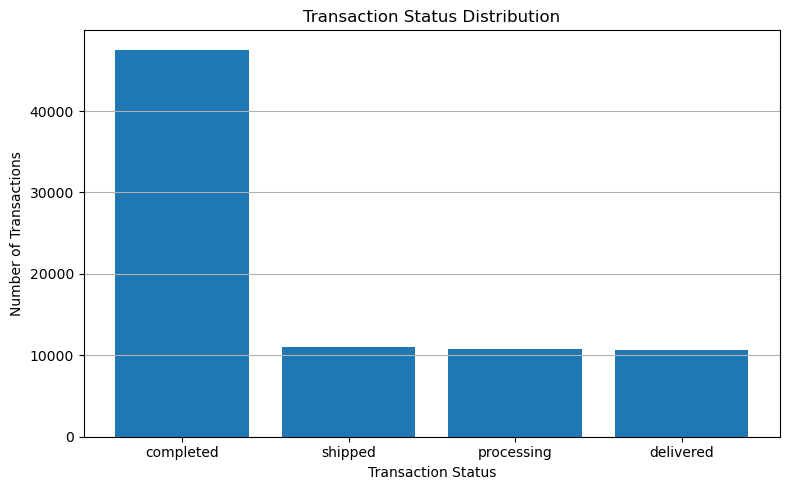

The above visualization illustrates the overall number of completed,
shipped, processed, and delivered transactions.

## Let Ensure timestamp is usable

In \[13\]:

    transactions_ts = transactions.withColumn(
        "timestamp_ts", to_timestamp("timestamp")
    )

    transactions_ts.select("timestamp", "timestamp_ts").show(5, truncate=False)

    +-------------------+-------------------+
    |timestamp          |timestamp_ts       |
    +-------------------+-------------------+
    |2025-12-27T14:56:06|2025-12-27 14:56:06|
    |2026-01-18T03:25:23|2026-01-18 03:25:23|
    |2026-01-21T08:00:37|2026-01-21 08:00:37|
    |2025-12-26T00:20:54|2025-12-26 00:20:54|
    |2026-01-09T07:14:31|2026-01-09 07:14:31|
    +-------------------+-------------------+
    only showing top 5 rows

## DAILY Revenue Trend Visualization

## 

In \[14\]:

    from pyspark.sql.functions import to_date, sum as spark_sum

    daily_revenue = transactions_ts.withColumn(
        "date", to_date("timestamp_ts")
    ).groupBy("date").agg(
        spark_sum("total").alias("daily_revenue")
    ).orderBy("date")

    daily_revenue.show(10)

    +----------+-----------------+
    |      date|    daily_revenue|
    +----------+-----------------+
    |2025-10-24|        163417.58|
    |2025-10-25|882781.6200000003|
    |2025-10-26|853720.4000000008|
    |2025-10-27|900701.2400000003|
    |2025-10-28|881323.4299999997|
    |2025-10-29|843232.7500000007|
    |2025-10-30|938767.5200000001|
    |2025-10-31|848440.4700000009|
    |2025-11-01|862756.5499999995|
    |2025-11-02|851404.9100000007|
    +----------+-----------------+
    only showing top 10 rows

In \[15\]:

    pdf_daily = daily_revenue.toPandas()
    pdf_daily.head()

Out\[15\]:

|     | date       | daily_revenue |
|-----|------------|---------------|
| 0   | 2025-10-24 | 163417.58     |
| 1   | 2025-10-25 | 882781.62     |
| 2   | 2025-10-26 | 853720.40     |
| 3   | 2025-10-27 | 900701.24     |
| 4   | 2025-10-28 | 881323.43     |

**Plot Daily Revenue**

In \[16\]:

    #Plot Daily Revenue
    plt.figure(figsize=(10,5))
    plt.plot(
        pdf_daily["date"],
        pdf_daily["daily_revenue"],
        marker="o"
    )

    plt.title("Daily Revenue Trend")
    plt.xlabel("Date")
    plt.ylabel("Revenue")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

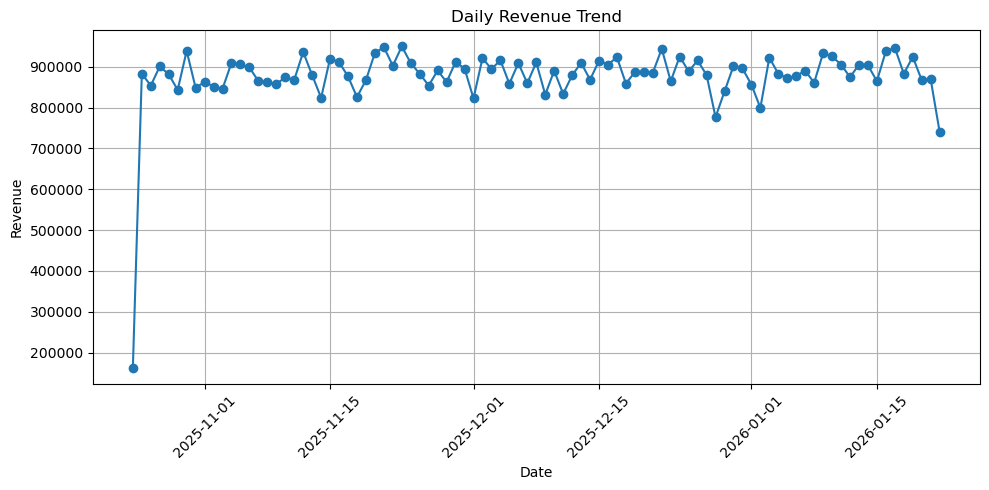

**Interpretation:** The above visualization highlights customer payment
preferences. The results provide insight into dominant payment channels,
supporting strategic decisions related to payment integrations and
customer convenience.

## MONTHLY Revenue Trend Visualization

In \[17\]:

    monthly_revenue = transactions_ts.withColumn(
        "month", date_format("timestamp_ts", "yyyy-MM")
    ).groupBy("month").agg(
        spark_sum("total").alias("monthly_revenue")
    ).orderBy("month")

    monthly_revenue.show()

    +-------+--------------------+
    |  month|     monthly_revenue|
    +-------+--------------------+
    |2025-10|   6312385.009999987|
    |2025-11|2.6578549069999978E7|
    |2025-12|  2.73929638799999E7|
    |2026-01|  1.94394916299999E7|
    +-------+--------------------+

In \[18\]:

    pdf_monthly = monthly_revenue.toPandas()
    pdf_monthly.head()

Out\[18\]:

|     | month   | monthly_revenue |
|-----|---------|-----------------|
| 0   | 2025-10 | 6312385.01      |
| 1   | 2025-11 | 26578549.07     |
| 2   | 2025-12 | 27392963.88     |
| 3   | 2026-01 | 19439491.63     |

In \[19\]:

    plt.figure(figsize=(10,5))
    plt.plot(
        pdf_monthly["month"],
        pdf_monthly["monthly_revenue"],
        marker="o"
    )

    plt.title("Monthly Revenue Trend")
    plt.xlabel("Month")
    plt.ylabel("Revenue")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

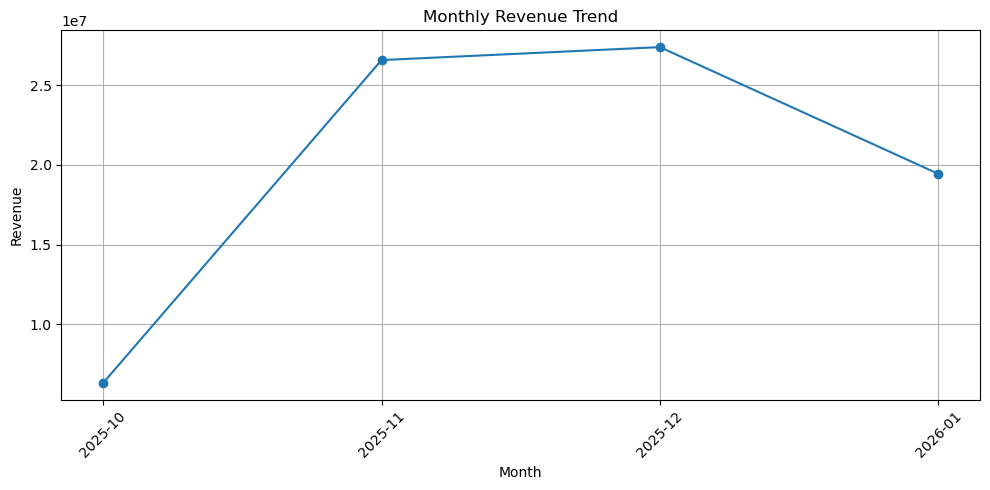

**Interpretation:** The monthly revenue trend smooths daily fluctuations
and reveals broader sales patterns, supporting seasonal and performance
analysis

## YEARLY Revenue Trend visualization

In \[20\]:

    yearly_revenue = transactions_ts.withColumn(
        "year", year("timestamp_ts")
    ).groupBy("year").agg(
        spark_sum("total").alias("yearly_revenue")
    ).orderBy("year")

    yearly_revenue.show()

    +----+-------------------+
    |year|     yearly_revenue|
    +----+-------------------+
    |2025|6.028389796000006E7|
    |2026| 1.94394916299999E7|
    +----+-------------------+

In \[21\]:

    pdf_yearly = yearly_revenue.toPandas()
    pdf_yearly.head()

Out\[21\]:

|     | year | yearly_revenue |
|-----|------|----------------|
| 0   | 2025 | 60283897.96    |
| 1   | 2026 | 19439491.63    |

In \[22\]:

    plt.figure(figsize=(8,5))
    plt.bar(
        pdf_yearly["year"].astype(str),
        pdf_yearly["yearly_revenue"]
    )

    plt.title("Yearly Revenue Trend")
    plt.xlabel("Year")
    plt.ylabel("Revenue")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

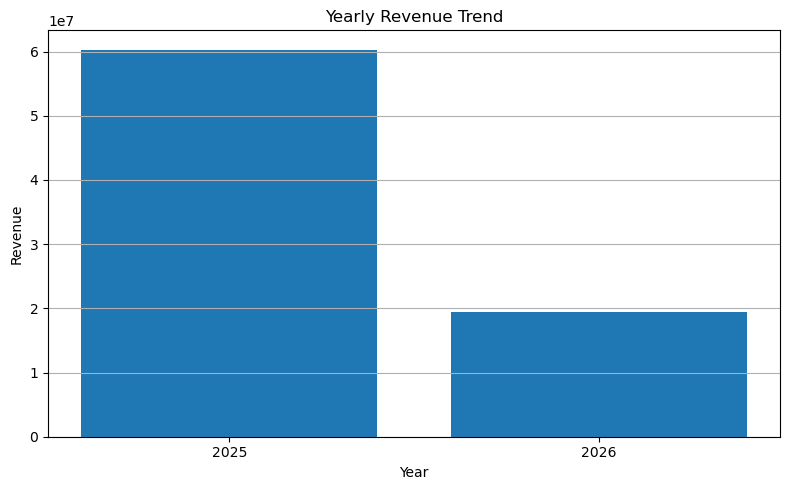

**Interpretation:** The yearly revenue trend highlights long-term
business growth and overall performance, useful for strategic planning
and forecasting

## Revenue by Payment Method

In \[23\]:

    payment_revenue = transactions.groupBy("payment_method").agg(
        spark_sum("total").alias("total_revenue")
    ).orderBy("total_revenue", ascending=False)

    payment_revenue.show()

    +--------------+--------------------+
    |payment_method|       total_revenue|
    +--------------+--------------------+
    |   credit_card|2.0168292369999915E7|
    | bank_transfer| 1.987847199000002E7|
    |        paypal|  1.97537828199999E7|
    |     gift_card|1.3559049220000042E7|
    |     apple_pay|   6363793.189999958|
    +--------------+--------------------+

In \[24\]:

    pdf_payment = payment_revenue.toPandas()
    pdf_payment.head()

Out\[24\]:

|     | payment_method | total_revenue |
|-----|----------------|---------------|
| 0   | credit_card    | 20168292.37   |
| 1   | bank_transfer  | 19878471.99   |
| 2   | paypal         | 19753782.82   |
| 3   | gift_card      | 13559049.22   |
| 4   | apple_pay      | 6363793.19    |

In \[25\]:

    plt.figure(figsize=(8,5))
    plt.bar(
        pdf_payment["payment_method"],
        pdf_payment["total_revenue"]
    )

    plt.title("Revenue by Payment Method")
    plt.xlabel("Payment Method")
    plt.ylabel("Total Revenue")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

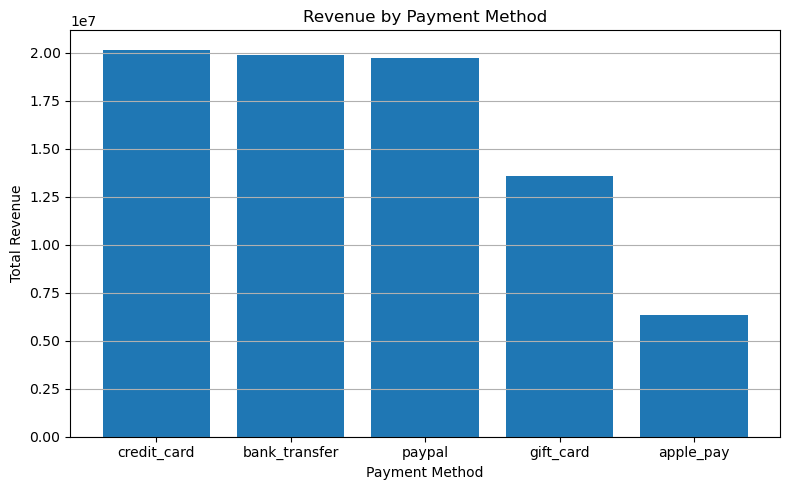

**Interpretation:** This visualization shows how revenue is distributed
across different payment methods, helping identify the most preferred
and profitable payment channels.

## Top Products by Revenue

**Explode items**

In \[26\]:

    #Explode items
    items_df = transactions.select(
        explode("items").alias("item")
    )

    items_df.show(5, truncate=False)

    +-------------------------------+
    |item                           |
    +-------------------------------+
    |{prod_00764, 1, 288.88, 288.88}|
    |{prod_00747, 1, 421.93, 421.93}|
    |{prod_01719, 3, 203.91, 67.97} |
    |{prod_01956, 3, 598.44, 199.48}|
    |{prod_02959, 2, 547.04, 273.52}|
    +-------------------------------+
    only showing top 5 rows

**Explode items**

In \[27\]:

    products_df = items_df.select(
        col("item.product_id").alias("product_id"),
        col("item.quantity").alias("quantity"),
        col("item.subtotal").alias("revenue")
    )

    products_df.show(5)

    +----------+--------+-------+
    |product_id|quantity|revenue|
    +----------+--------+-------+
    |prod_00764|       1| 288.88|
    |prod_00747|       1| 421.93|
    |prod_01719|       3| 203.91|
    |prod_01956|       3| 598.44|
    |prod_02959|       2| 547.04|
    +----------+--------+-------+
    only showing top 5 rows

**Aggregate revenue by product category**

In \[28\]:

    top_products = products_df.groupBy("product_id").agg(
        spark_sum("revenue").alias("total_revenue"),
        spark_sum("quantity").alias("total_quantity")
    ).orderBy("total_revenue", ascending=False)

    top_products.show(10)

    +----------+-----------------+--------------+
    |product_id|    total_revenue|total_quantity|
    +----------+-----------------+--------------+
    |prod_00247|92711.20000000007|           170|
    |prod_00150|92687.39999999998|           156|
    |prod_02977|90697.32000000007|           162|
    |prod_02794|86424.45000000001|           159|
    |prod_02819|83723.19999999992|           160|
    |prod_00002| 82147.5200000001|           169|
    |prod_00984|81830.72000000006|           152|
    |prod_01258| 81582.6600000001|           153|
    |prod_02324|79885.44999999992|           155|
    |prod_00330|79506.44999999997|           171|
    +----------+-----------------+--------------+
    only showing top 10 rows

In \[29\]:

    pdf_products = top_products.limit(10).toPandas()
    pdf_products.head()

Out\[29\]:

|     | product_id | total_revenue | total_quantity |
|-----|------------|---------------|----------------|
| 0   | prod_00247 | 92711.20      | 170            |
| 1   | prod_00150 | 92687.40      | 156            |
| 2   | prod_02977 | 90697.32      | 162            |
| 3   | prod_02794 | 86424.45      | 159            |
| 4   | prod_02819 | 83723.20      | 160            |

## Visualization (Top 10 Products)

In \[30\]:

    plt.figure(figsize=(10,5))
    plt.bar(
        pdf_products["product_id"],
        pdf_products["total_revenue"]
    )

    plt.title("Top 10 Products by Revenue")
    plt.xlabel("Product ID")
    plt.ylabel("Revenue")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

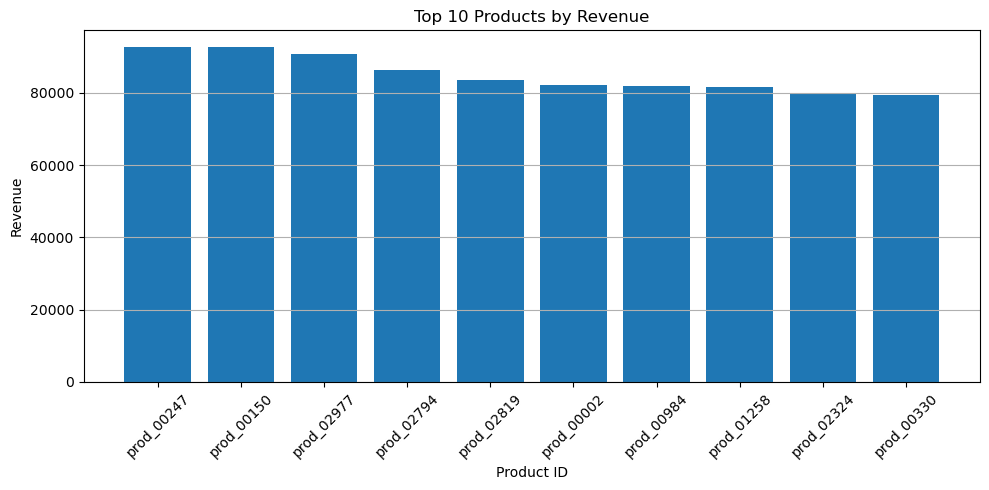

**Interpretation:** The top products by revenue represent the most
profitable items in the platform and can guide inventory planning and
marketing strategies

## Aggregate spending per customer (Spark)

In \[31\]:

    customer_spending = transactions.groupBy("user_id").agg(
        spark_sum("total").alias("total_spent"),
        count("*").alias("num_transactions")
    ).orderBy("total_spent", ascending=False)

    customer_spending.show(10)

    +-----------+------------------+----------------+
    |    user_id|       total_spent|num_transactions|
    +-----------+------------------+----------------+
    |user_004845| 37574.23000000001|              29|
    |user_000399|35433.009999999995|              31|
    |user_000971|35198.530000000006|              30|
    |user_003083| 35133.23999999998|              32|
    |user_001470|35131.869999999995|              23|
    |user_003110|          34630.02|              28|
    |user_003308|          34323.03|              28|
    |user_000135|33874.299999999996|              27|
    |user_004323|33746.329999999994|              28|
    |user_004027|          33511.12|              31|
    +-----------+------------------+----------------+
    only showing top 10 rows

In \[32\]:

    pdf_customers = customer_spending.toPandas()
    pdf_customers.head()

Out\[32\]:

|     | user_id     | total_spent | num_transactions |
|-----|-------------|-------------|------------------|
| 0   | user_004845 | 37574.23    | 29               |
| 1   | user_000399 | 35433.01    | 31               |
| 2   | user_000971 | 35198.53    | 30               |
| 3   | user_003083 | 35133.24    | 32               |
| 4   | user_001470 | 35131.87    | 23               |

In \[33\]:

    plt.figure(figsize=(10,5))
    plt.hist(
        pdf_customers["total_spent"],
        bins=50
    )

    plt.title("Distribution of Customer Total Spending")
    plt.xlabel("Total Spending")
    plt.ylabel("Number of Customers")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

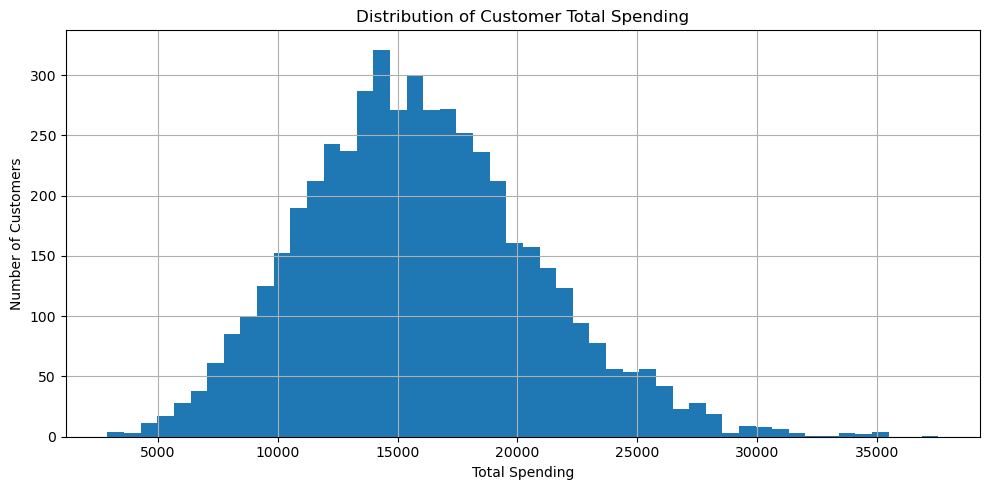

**Interpretation:** The histogram shows that most customers fall into
lower spending ranges, while a smaller group of high-value customers
contributes disproportionately to total revenue, reflecting typical
e-commerce purchasing behavior.

## Customer Segmentation (Low / Medium / High spenders)

In \[34\]:

    pdf_customers["spending_segment"] = pd.qcut(
        pdf_customers["total_spent"],
        q=3,
        labels=["Low", "Medium", "High"]
    )

    pdf_customers["spending_segment"].value_counts()

Out\[34\]:

    spending_segment
    Low       1667
    High      1667
    Medium    1666
    Name: count, dtype: int64

**Visualize segments**

In \[35\]:

    #Visualize segments
    segment_counts = pdf_customers["spending_segment"].value_counts()

    plt.figure(figsize=(6,5))
    segment_counts.plot(kind="bar")

    plt.title("Customer Spending Segments")
    plt.xlabel("Spending Segment")
    plt.ylabel("Number of Customers")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

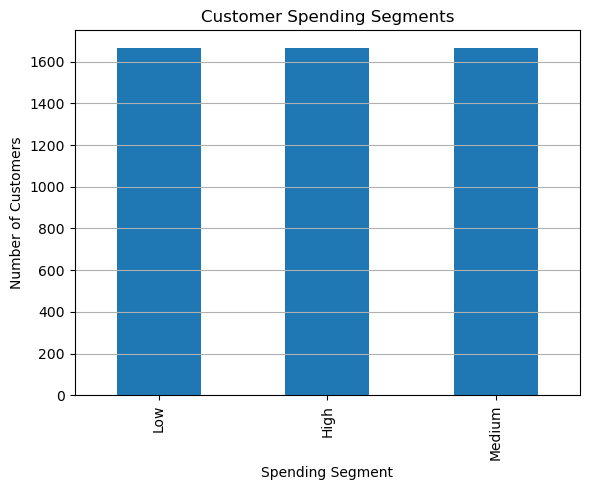

**Interpretation:** Customers can be grouped into low, medium, and high
spending segments. High-value customers, though fewer in number,
represent a critical segment for revenue optimization and targeted
marketing strategies.

## Relationship: Transactions vs Spending

## 

In \[36\]:

    #Behavioral insight.
    plt.figure(figsize=(8,5))
    plt.scatter(
        pdf_customers["num_transactions"],
        pdf_customers["total_spent"],
        alpha=0.5
    )

    plt.title("Customer Transactions vs Total Spending")
    plt.xlabel("Number of Transactions")
    plt.ylabel("Total Spending")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

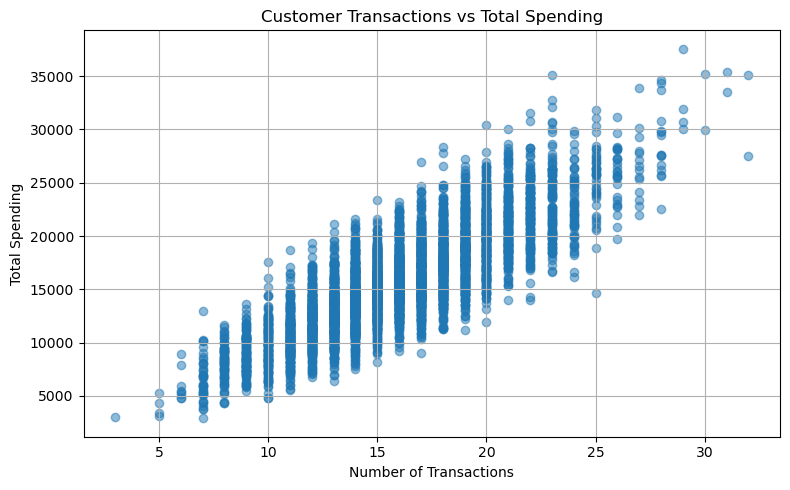

**Interpretation:** The scatter plot reveals a positive relationship
between transaction frequency and total spending, indicating that repeat
customers tend to generate higher revenue.

## Sessions Analysis

In \[37\]:

    df = pd.read_json("/project/data_raw/sessions_0.json")

In \[38\]:

    df.head()

Out\[38\]:

|     | session_id      | user_id     | start_time          | end_time            | duration_seconds | geo_data                                          | device_profile                                    | viewed_products                                    | page_views                                         | cart_contents                                     | conversion_status | referrer      |
|-----|-----------------|-------------|---------------------|---------------------|------------------|---------------------------------------------------|---------------------------------------------------|----------------------------------------------------|----------------------------------------------------|---------------------------------------------------|-------------------|---------------|
| 0   | sess_7a66c5c32d | user_000451 | 2025-12-06 10:01:44 | 2025-12-06 10:10:12 | 508              | {'city': 'Davidstad', 'state': 'VA', 'country'... | {'type': 'desktop', 'os': 'Android', 'browser'... | \[prod_00229, prod_02385, prod_02028, prod_0150... | \[{'timestamp': '2025-12-06T10:01:44', 'page_ty... | {'prod_01316': {'quantity': 2, 'price': 93.88}... | abandoned         | search_engine |
| 1   | sess_21a9b1958b | user_003303 | 2025-11-08 12:33:37 | 2025-11-08 13:26:12 | 3155             | {'city': 'East Rebeccahaven', 'state': 'NY', '... | {'type': 'desktop', 'os': 'iOS', 'browser': 'S... | \[prod_00701, prod_02146, prod_00659, prod_0223... | \[{'timestamp': '2025-11-08T12:33:37', 'page_ty... | {'prod_00799': {'quantity': 2, 'price': 428.64... | abandoned         | email         |
| 2   | sess_3f5bd4a577 | user_000643 | 2025-11-23 15:01:55 | 2025-11-23 15:43:34 | 2499             | {'city': 'Martinezton', 'state': 'IL', 'countr... | {'type': 'tablet', 'os': 'iOS', 'browser': 'Sa... | \[prod_02030, prod_00304\]                         | \[{'timestamp': '2025-11-23T15:01:55', 'page_ty... | {}                                                | browsed           | affiliate     |
| 3   | sess_e3e3b9e3e7 | user_001153 | 2025-12-27 13:56:37 | 2025-12-27 14:56:06 | 3569             | {'city': 'West Claudia', 'state': 'IN', 'count... | {'type': 'desktop', 'os': 'macOS', 'browser': ... | \[prod_01719, prod_00747, prod_00764, prod_0102... | \[{'timestamp': '2025-12-27T13:56:37', 'page_ty... | {'prod_00764': {'quantity': 1, 'price': 288.88... | converted         | search_engine |
| 4   | sess_f4849121ba | user_004418 | 2025-12-15 05:49:56 | 2025-12-15 06:07:01 | 1025             | {'city': 'West Christopherview', 'state': 'DC'... | {'type': 'tablet', 'os': 'iOS', 'browser': 'Ed... | \[prod_00093, prod_00487\]                         | \[{'timestamp': '2025-12-15T05:49:56', 'page_ty... | {}                                                | browsed           | search_engine |

In \[39\]:

    df.columns

Out\[39\]:

    Index(['session_id', 'user_id', 'start_time', 'end_time', 'duration_seconds',
           'geo_data', 'device_profile', 'viewed_products', 'page_views',
           'cart_contents', 'conversion_status', 'referrer'],
          dtype='object')

In \[40\]:

    df = pd.read_json("/project/data_raw/sessions_0.json")

    # Use start_time directly
    df['date'] = pd.to_datetime(df['start_time']).dt.date

    daily_sessions = df.groupby('date').size()

    plt.figure(figsize=(8,4))
    daily_sessions.plot(kind='line')
    plt.title("Daily User Sessions (Time-Series)")
    plt.xlabel("Date")
    plt.ylabel("Number of Sessions")
    plt.tight_layout()
    plt.show()

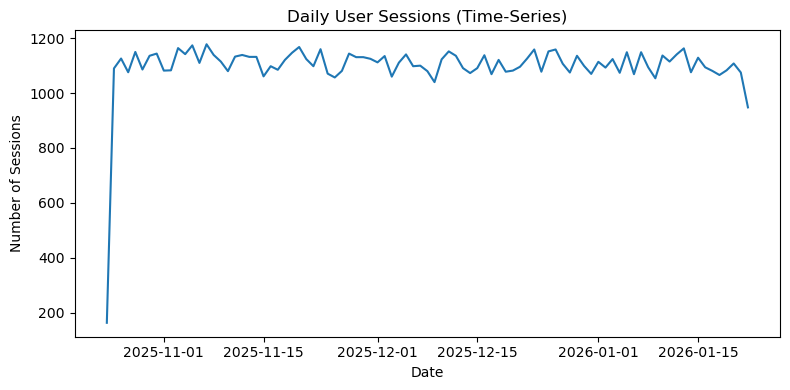

**Intepretation:** Daily session activity visualized by aggregating
session start times, providing a time-series view of user engagement
patterns.

In \[41\]:

    df = pd.read_json("/project/data_raw/sessions_0.json")
    df['start_time'].head()

Out\[41\]:

    0   2025-12-06 10:01:44
    1   2025-11-08 12:33:37
    2   2025-11-23 15:01:55
    3   2025-12-27 13:56:37
    4   2025-12-15 05:49:56
    Name: start_time, dtype: datetime64[ns]

#### HOURLY SESSION DISTRIBUTION

In \[42\]:

    df = pd.read_json("/project/data_raw/sessions_0.json")

    df['start_time'] = pd.to_datetime(df['start_time'])
    df['hour'] = df['start_time'].dt.hour

    hourly_sessions = df.groupby('hour').size()

    plt.figure(figsize=(8,4))
    hourly_sessions.plot(kind='bar')
    plt.title("Hourly Distribution of User Sessions")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Sessions")
    plt.tight_layout()
    plt.show()

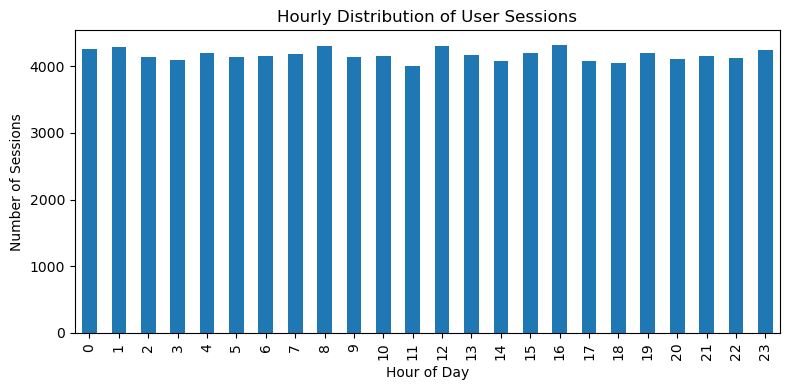

**Interpretation:** Hourly session analysis reveals peak user activity
periods, indicating the times of day when the platform experiences the
highest engagement.

## MONTHLY SESSION VOLUME

In \[43\]:

    df['month'] = df['start_time'].dt.to_period('M')

    monthly_sessions = df.groupby('month').size()

    plt.figure(figsize=(8,4))
    monthly_sessions.plot(kind='bar')
    plt.title("Monthly User Sessions")
    plt.xlabel("Month")
    plt.ylabel("Number of Sessions")
    plt.tight_layout()
    plt.show()

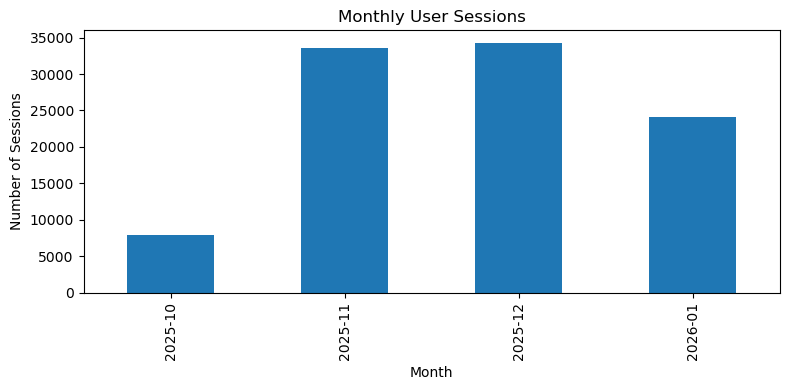

**Interpretation:** Monthly session aggregation highlights longer-term
engagement trends and potential seasonal effects in user activity.

#### YEARLY SESSION COUNT

In \[44\]:

    df['year'] = df['start_time'].dt.year

    yearly_sessions = df.groupby('year').size()

    plt.figure(figsize=(6,4))
    yearly_sessions.plot(kind='bar')
    plt.title("Yearly User Sessions")
    plt.xlabel("Year")
    plt.ylabel("Number of Sessions")
    plt.tight_layout()
    plt.show()

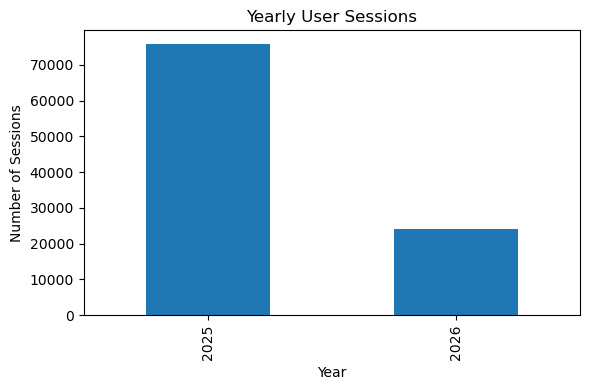

**Interpretation:** Yearly session aggregation provides a high-level
overview of platform usage and supports long-term capacity planning.

In \[7\]:

    spark

Out\[7\]:

**SparkSession - in-memory**

**SparkContext**

[Spark UI](http://d1b837b3df99:4041)

Version  
`v3.5.0`

Master  
`local[*]`

AppName  
`Ecommerce Big Data Visualization`

In \[27\]:

    sessions = spark.read.option("multiLine", True).json("/project/data_raw/sessions_*.json")
    transactions = spark.read.option("multiLine", True).json("/project/data_raw/transactions.json")
    products = spark.read.option("multiLine", True).json("/project/data_raw/products.json")

In \[20\]:

    transactions.count()

Out\[20\]:

    80000

In \[19\]:

    sessions.count()

Out\[19\]:

    300000

In \[28\]:

    sessions.createOrReplaceTempView("sessions")
    transactions.createOrReplaceTempView("transactions")
    products.createOrReplaceTempView("products")

### Funnel conversion

In \[45\]:

    #Funnel conversion query
    funnel_df=spark.sql("""
    SELECT
        COUNT(DISTINCT s.session_id) AS total_sessions,
        COUNT(DISTINCT t.transaction_id) AS total_transactions,
        ROUND(
            COUNT(DISTINCT t.transaction_id) * 100.0 /
            COUNT(DISTINCT s.session_id), 2
        ) AS conversion_rate_percent
    FROM sessions s
    LEFT JOIN transactions t
    ON s.session_id = t.session_id
    """)
    funnel_df.show()

    +--------------+------------------+-----------------------+
    |total_sessions|total_transactions|conversion_rate_percent|
    +--------------+------------------+-----------------------+
    |        299999|             36755|                  12.25|
    +--------------+------------------+-----------------------+

### Funnel conversion Visulaization

In \[46\]:

    stages = ["Sessions", "Transactions"]
    values = [
        int(pdf["total_sessions"][0]),
        int(pdf["total_transactions"][0])
    ]
    conversion_rate = pdf["conversion_rate_percent"][0]

    plt.figure()
    plt.bar(stages, values)
    plt.title("Funnel Conversion: Sessions → Transactions")
    plt.xlabel("Funnel Stage")
    plt.ylabel("Count")

    # Add conversion rate annotation
    plt.text(
        0.5,
        max(values) * 0.6,
        f"Conversion Rate: {conversion_rate}%",
        ha="center",
        fontsize=10
    )

    plt.tight_layout()
    plt.show()

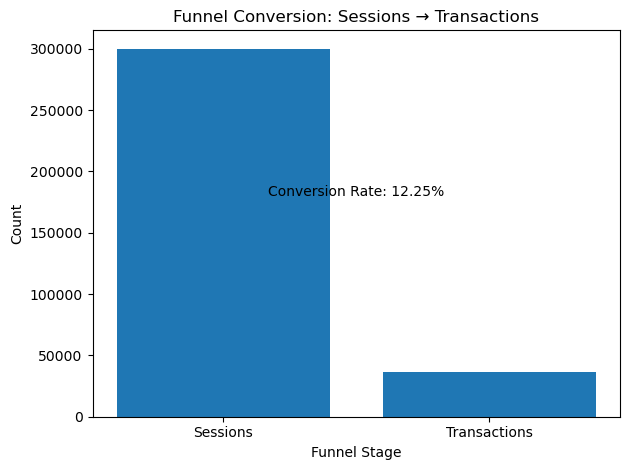

## Product affinity analysis combining transaction data and Spark processing

In \[47\]:

    #Generate product pairs and count co-occurrence
    product_affinity_df = spark.sql("""
    SELECT
        CONCAT(a.product_id, ' - ', b.product_id) AS pair,
        COUNT(*) AS frequency
    FROM transaction_products a
    JOIN transaction_products b
    ON a.transaction_id = b.transaction_id
    AND a.product_id < b.product_id
    GROUP BY pair
    ORDER BY frequency DESC
    LIMIT 10
    """)
    product_affinity_df.show(truncate=False)

    +-----------------------+---------+
    |pair                   |frequency|
    +-----------------------+---------+
    |prod_02030 - prod_02292|3        |
    |prod_01436 - prod_02409|3        |
    |prod_02223 - prod_02347|3        |
    |prod_00566 - prod_00889|3        |
    |prod_00674 - prod_01702|3        |
    |prod_00312 - prod_00325|3        |
    |prod_01984 - prod_02554|3        |
    |prod_00244 - prod_02846|3        |
    |prod_01473 - prod_02303|3        |
    |prod_00890 - prod_01553|3        |
    +-----------------------+---------+

In \[49\]:

    pdf_affinity = product_affinity_df.toPandas()

### Product affinity analysis Visualization

In \[50\]:

    plt.figure()
    plt.barh(pdf_affinity["pair"], pdf_affinity["frequency"])
    plt.xlabel("Frequency")
    plt.ylabel("Product Pair")
    plt.title("Top 10 Product Affinities (Market Basket Analysis)")
    plt.gca().invert_yaxis()  # highest frequency on top
    plt.tight_layout()
    plt.show()

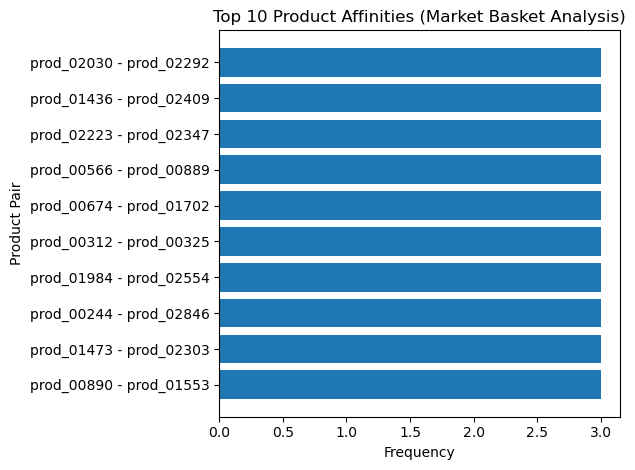

## Revenue trends enriched with behavioral context.

In \[58\]:

    #Revenue trends enriched with behavioral context
    revenue_df = spark.sql("""
    SELECT
        SUBSTRING(t.timestamp, 1, 7) AS month,
        COUNT(DISTINCT s.session_id) AS total_sessions,
        COUNT(DISTINCT t.transaction_id) AS total_transactions,
        ROUND(SUM(t.total), 2) AS monthly_revenue
    FROM sessions s
    LEFT JOIN transactions t
    ON s.session_id = t.session_id
    WHERE t.timestamp IS NOT NULL
    GROUP BY SUBSTRING(t.timestamp, 1, 7)
    ORDER BY month
    """)

    revenue_df.show()

    +-------+--------------+------------------+---------------+
    |  month|total_sessions|total_transactions|monthly_revenue|
    +-------+--------------+------------------+---------------+
    |2025-10|          2862|              2862|      1980988.6|
    |2025-11|         12461|             12461|     8685246.24|
    |2025-12|         12589|             12589|      8814814.0|
    |2026-01|          8843|              8843|      6213550.6|
    +-------+--------------+------------------+---------------+

In \[59\]:

    #onvert to Pandas
    pdf_revenue = revenue_df.toPandas()

### Revenue trends Visualization

In \[60\]:

    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(
        pdf_revenue["month"],
        pdf_revenue["monthly_revenue"],
        marker="o"
    )
    plt.title("Monthly Revenue Trends Enriched with Behavioral Context")
    plt.xlabel("Month")
    plt.ylabel("Monthly Revenue")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

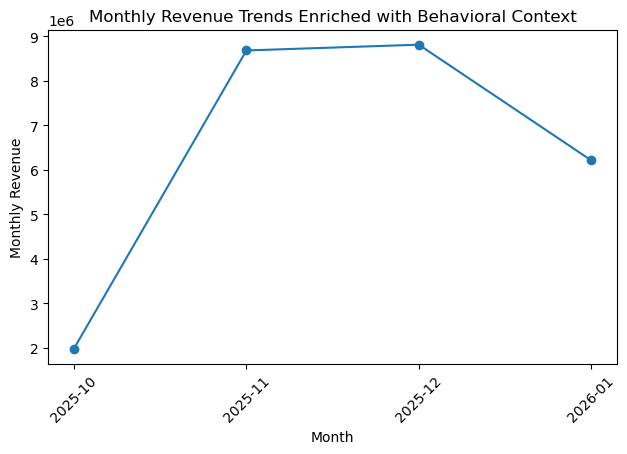